In [1]:
# Custom Imports
import sys
sys.path.append("..")
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#dataset = "pathmnist"
#dataset = "bloodmnist"
#dataset = "retinamnist"
dataset = "dermamnist"
nchan = 3

#dataset = "pneumoniamnist"
#dataset = "tissuemnist"

data = np.load('Datasets/%s.npz'%(dataset))


y_train = np.squeeze(data['train_labels'])
y_val = np.squeeze(data['val_labels'])
y_test = np.squeeze(data['test_labels'])


if(dataset in ["pathmnist", "bloodmnist", "retinamnist", "dermamnist"]):
    X_train = np.swapaxes(data['train_images'], 3, 1)/255.0
    X_val = np.swapaxes(data['val_images'], 3, 1)/255.0
    X_test = np.swapaxes(data['test_images'], 3, 1)/255.0
    
elif(dataset in ["tissuemnist", "pneumoniamnist"]):
    X_train = data['train_images']/255.0
    X_train = X_train[0:20000]
    y_train = y_train[0:20000]
    X_train = X_train[:,None]
    X_val = data['val_images']/255.0
    X_val = X_val[0:2000]
    y_val = y_val[0:2000]
    X_val = X_val[:,None]
    X_test = data['test_images']/255.0
    X_test = X_test[:,None]
    
#y_train = torch.nn.functional.one_hot(torch.Tensor(data['train_labels']).to(torch.int64), 10)
#y_val = torch.nn.functional.one_hot(torch.Tensor(data['val_labels']).to(torch.int64), 10)
#y_test = torch.nn.functional.one_hot(torch.Tensor(data['test_labels']).to(torch.int64), 10)

print("train: ", X_train.shape)
print("test: ", X_test.shape)

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_train, y_train)  
CustVal = custDataset(X_val, y_val) 
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=100):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustVal, CustTest)

train:  (7007, 3, 28, 28)
test:  (2005, 3, 28, 28)


In [2]:
ALPHA = 0.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.0        # Input Peturbation Budget at Training Time
GAMMA = 0.0            # Model Peturbation Budget at Training Time 
                        #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.0025      # Learning Rate Hyperparameter
HIDDEN_DIM = 100       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 1         # Hidden Layers Hyperparameter
MAX_EPOCHS = 20

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [3]:
if(dataset == "pneumoniamnist"):
    ncls = 2
    model = XAIArchitectures.DeepMindSmall(dataset="PNEUMONIAMNIST")
elif(dataset == "tissuemnist"):
    ncls = 8
    model = XAIArchitectures.DeepMindSmall(dataset='TISSUEMNIST')
elif(dataset == "dermamnist"):
    ncls = 7
    model = XAIArchitectures.DeepMindSmall(dataset='DERMAMNIST')
else:
    ncls = 10
    model = XAIArchitectures.DeepMindSmall(dataset="MEDMNIST")


In [4]:

SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR 
MODEL_ID = "DeepMindSmall_%s_e=%s_g=%s_a=%s_s=%s"%(dataset, EPSILON, GAMMA, ALPHA, SCHEDULED)
print(MODEL_ID)
ckpt = torch.load("Models/%s.ckpt"%(MODEL_ID))

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load("Models/%s.ckpt"%(MODEL_ID))
for key in checkpoint:
    print(key)
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))


DeepMindSmall_dermamnist_e=0.0_g=0.0_a=0.0_s=True
epoch
global_step
pytorch-lightning_version
state_dict
loops
callbacks
optimizer_states
lr_schedulers
hparams_name
hyper_parameters


<All keys matched successfully>

In [5]:

acc = 0
for i in range(len(X_test)):
    data = np.asarray(X_test[i]).reshape(nchan,28,28)
    out, cls = model.classify(torch.Tensor([data]))
    if(cls == y_test[i]):
        acc += 1
print(acc/len(X_test))


/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  after removing the cwd from sys.path.


0.7197007481296758


../GradCertModule.py:282: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  return dL_min.T, dL_max.T #dL_dz_min.T, dL_dz_max.T


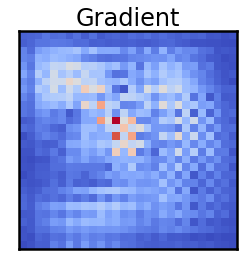

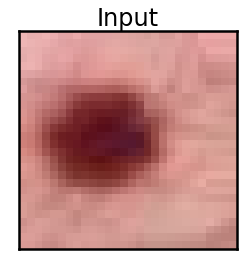

In [6]:
inp = 0

import seaborn as sns
sns.set_context('poster')

data = np.asarray(X_test[inp])
data_master = np.asarray(X_test[inp])
data = torch.Tensor(data)
target = torch.Tensor([y_test[inp]]).to(torch.int64)
gra = GradCertModule.InputGrad(model, data[None, :], target, nclasses=ncls)
gra = gra.detach().numpy()
if(nchan == 3):
    gra = np.sum(np.abs(np.squeeze(gra)), -1)
else:
    gra = np.squeeze(gra.T)
gra = np.abs(gra)


plt.imshow(gra, cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('Gradient')
plt.show()

if(nchan == 3):
    data = np.asarray(X_test[inp])
    data =  np.swapaxes(np.squeeze(data), 0, 2)
else:
    data = np.asarray(X_test[inp]).reshape(28,28)
data = torch.Tensor(data)
plt.imshow(np.squeeze(data.detach().numpy()))
plt.xticks([])
plt.yticks([])
plt.title('Input')
plt.show()


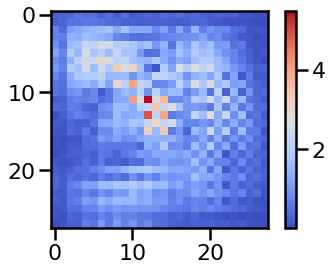

In [7]:
#gra =  np.swapaxes(np.squeeze(gra), 0, 2)
#gra = np.sum(np.abs(np.squeeze(gra)), -1)

gra = np.squeeze(gra)
plt.imshow(gra, cmap='coolwarm')
plt.colorbar()
plt.show()

In [8]:
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
model.inputfooling_ON()

if(nchan == 3):
    data = np.asarray(X_test[inp])
    #data =  np.swapaxes(np.squeeze(data), 0, 2)
    print(data.shape)
    data = torch.Tensor(data)
    
min_grad, max_grad = GradCertModule.GradCertBounds(model, data[None, :], target, 0.05, 0.0, nclasses=ncls)
min_grad, max_grad = min_grad.detach().numpy().T, max_grad.detach().numpy().T


print(min_grad.shape)
if(nchan == 3):
    min_grad = np.swapaxes(np.squeeze(min_grad), 0, -1)
    max_grad = np.swapaxes(np.squeeze(max_grad), 0, -1)
    min_grad = np.sum(np.squeeze(min_grad), -1)
    max_grad = np.sum(np.squeeze(max_grad), -1)


(3, 28, 28)
(1, 3, 28, 28)


False


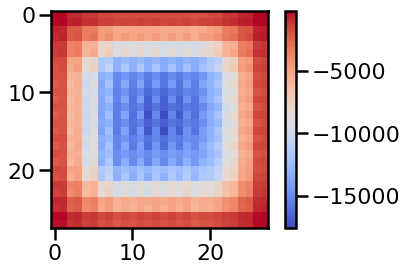

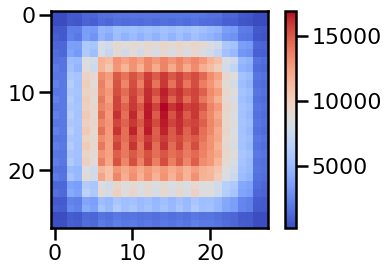

In [9]:
print((max_grad == min_grad).all())
min_grad = np.squeeze(min_grad)
plt.imshow(min_grad, cmap='coolwarm')
plt.colorbar()
plt.show()

max_grad = np.squeeze(max_grad)
plt.imshow(max_grad, cmap='coolwarm')
plt.colorbar()
plt.show()


In [10]:

model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

data = np.asarray(X_test[inp])
data = torch.Tensor(data)

succ, x_adv, grad_adv, targex, loss = GradCertModule.run_mnist_attack(model, data, target=[5,5], epsilon=0.05, 
                                                  iterations=200, lr=0.01, shape=(3,28,28), label_reg=0.05)    
x_adv = np.squeeze(x_adv.detach().numpy())
grad_adv = np.squeeze(grad_adv.detach().numpy())


Loss: 0.09473206102848053: 100%|██████████████| 200/200 [00:06<00:00, 33.08it/s]


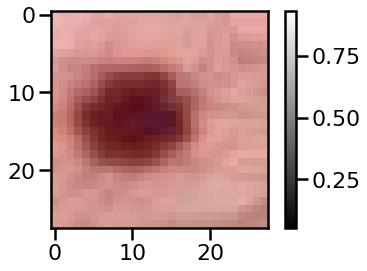

(3, 28, 28)


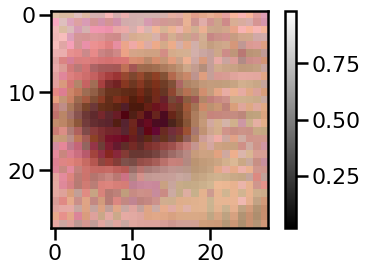

(3, 28, 28)


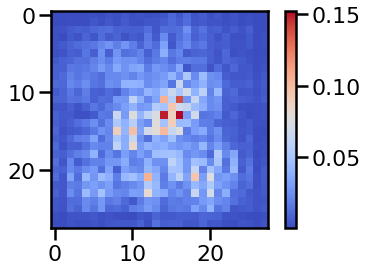

In [11]:
#print(x_adv)
viz = np.swapaxes(np.squeeze(data.detach().numpy()), 2, 0)
plt.imshow(viz, cmap='gray')
plt.colorbar()
plt.show()

print(x_adv.shape)
viz_adv = np.swapaxes(np.squeeze(x_adv), 2, 0)
plt.imshow(viz_adv, cmap='gray')
plt.colorbar()
plt.show()


print(grad_adv.shape)
g_adv = np.sum(np.abs(np.squeeze(grad_adv)), 0)
g_adv = np.rot90(np.rot90(g_adv))
plt.imshow(g_adv, cmap='coolwarm')
plt.colorbar()
plt.show()

../GradCertModule.py:786: UserWarning: Using a target size (torch.Size([3, 28, 28])) that is different to the input size (torch.Size([1, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = F.mse_loss(grad_adv, target_expl)


0.0916309729218483
(3, 28, 28)


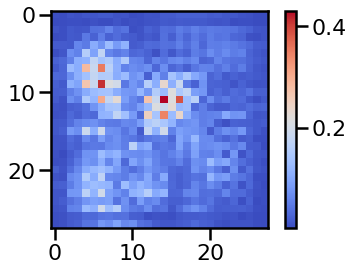

In [12]:
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

succ, x_adv, grad_adv, targex = GradCertModule.run_model_attack(model, data, target=[5,5], gamma=0.2, 
                                                  iterations=250, lr=0.001, shape=(3,28,28), label_reg=0.05)

grad_adv = np.squeeze(grad_adv.detach().numpy())
print(grad_adv.shape)
g_adv = np.sum(np.abs(np.squeeze(grad_adv)), 0)
g_adv = g_adv.T
plt.imshow(g_adv, cmap='coolwarm')
plt.colorbar()
plt.show()



In [13]:
INDEX = inp
print(INDEX)

0


/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


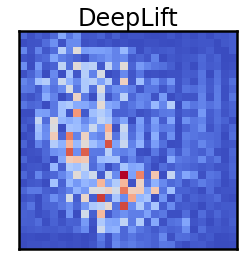

In [14]:
model.inputfooling_OFF()
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

from captum.attr import DeepLift

inp = np.asarray(X_test[INDEX]).reshape(1,nchan,28,28)
inp = torch.Tensor(inp)
base = 0.0 * inp

ig = DeepLift(model)
attributions, delta = ig.attribute(inp, base, target=0, return_convergence_delta=True)
attributions = np.sum(np.squeeze(attributions.detach().numpy()), axis=0)
attributions = np.abs(attributions)
plt.imshow(attributions, cmap = 'coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('DeepLift')
plt.show()

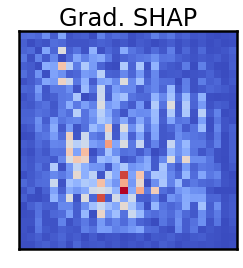

In [15]:
model.inputfooling_OFF()
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

from captum.attr import GradientShap

inp = np.asarray(X_test[INDEX]).reshape(1,nchan,28,28)
inp = torch.Tensor(inp)
base = 0.0 * inp

ig = GradientShap(model)
attributions, delta = ig.attribute(inp, base, target=0, return_convergence_delta=True)
attributions = np.sum(np.squeeze(attributions.detach().numpy()), axis=0)
attributions = np.abs(attributions)
plt.imshow(attributions, cmap = 'coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('Grad. SHAP')
plt.show()


In [16]:
# Test a few explanation methods

model.inputfooling_OFF()
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

# Standard Gradient

# Integrated Gradient

# Lime



<All keys matched successfully>

In [17]:
# Re-Compute Accuracy of the Model
model.inputfooling_OFF()
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))

acc = 0
for i in range(len(X_test)):
    d = np.asarray(X_test[i]).reshape(nchan,28,28)
    out, cls = model.classify(torch.Tensor([d]))
    if(cls == y_test[i]):
        acc += 1
print(acc/len(X_test))



0.7197007481296758


In [18]:
# Compute Joint Certified Robustness


def compute_input_robustness(model, data, target, eps, gam):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    grad = np.sum(np.squeeze(GradCertModule.InputGrad(model, data, targ, nclasses=ncls).detach().numpy()), axis=-1)
    model.inputfooling_ON()
    succ, x_adv, grad_adv, targex, loss = GradCertModule.run_mnist_attack(model, data, target=[5,5], epsilon=eps, 
                                                  iterations=20, lr=0.01, shape=(3,28,28), label_reg=0.05) 
    model.inputfooling_OFF()
    grad_adv = np.sum(np.squeeze(GradCertModule.InputGrad(model, x_adv, targ, nclasses=ncls).detach().numpy()), axis=-1)

    adv_g = grad_adv
    min_grad, max_grad = GradCertModule.GradCertBounds(model, data, target, eps, gam, nclasses=ncls)
    min_grad = np.sum(np.squeeze(min_grad.detach().numpy()), axis=-1).T
    max_grad = np.sum(np.squeeze(max_grad.detach().numpy()), axis=-1).T

    diff_up = max_grad - grad
    diff_down = grad - min_grad
    diff = np.maximum(diff_up, diff_down)
    
    loss_cert = ((diff)**2).mean()
    loss_grad = (((grad - adv_g)/np.max(grad))**2).mean()
    
    return loss_cert, loss_grad

in_cert = 0
in_attk = 0
for inp in range(100):
    data = np.asarray(X_test[inp])
    data = torch.Tensor(data)
    targ = torch.Tensor([y_test[inp]]).to(torch.int64)
    cert, attk = compute_input_robustness(model, data, targ, 0.025, 0.0)
    #print(cert, attk)
    if(cert <= 0.03):
        in_cert += 1
    if(attk <= 0.03):
        in_attk += 1
print(in_cert)
print(in_attk)

std_acc = 0.72
std_inp_atk = 0.66
std_inp_rob = 0.00

rob_acc = 0.67
rob_inp_atk = 0.98
rob_inp_rob = 0.78

Loss: 0.0950094535946846: 100%|█████████████████| 20/20 [00:00<00:00, 32.94it/s]

0
68


In [19]:
def compute_model_robustness(model, data, target, eps, gam):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    grad = np.sum(np.squeeze(GradCertModule.InputGrad(model, data, targ, nclasses=ncls).detach().numpy()), axis=-1)
    model.inputfooling_ON()
    succ, x_adv, grad_adv, targex = GradCertModule.run_model_attack(model, data, target=[5,5], gamma=gam, 
                                                      iterations=25, lr=0.001, shape=(3,28,28), label_reg=1.0)
    #model.inputfooling_OFF()
    grad_adv = np.sum(np.squeeze(grad_adv.detach().numpy()), axis=0)
    #grad_adv = np.sum(np.squeeze(GradCertModule.InputGrad(model, data, targ, nclasses=ncls).detach().numpy()), axis=-1)

    adv_g = grad_adv
    min_grad, max_grad = GradCertModule.GradCertBounds(model, data, target, eps, gam, nclasses=ncls)
    min_grad = np.sum(np.squeeze(min_grad.detach().numpy()), axis=-1).T
    max_grad = np.sum(np.squeeze(max_grad.detach().numpy()), axis=-1).T

    diff_up = max_grad - grad
    diff_down = grad - min_grad
    diff = np.maximum(diff_up, diff_down)
    
    loss_cert = ((diff)**2).mean()
    loss_grad = (((grad - adv_g)/np.max(grad))**2).mean()
    
    return loss_cert, loss_grad

mod_cert = 0
mod_attk = 0
for inp in range(100):
    data = np.asarray(X_test[inp])
    data = torch.Tensor(data)
    targ = torch.Tensor([y_test[inp]]).to(torch.int64)
    cert, attk = compute_model_robustness(model, data, targ, 0.05, 0.0)
    #print(cert, attk)
    if(cert <= 0.03):
        mod_cert += 1
    if(attk <= 0.03):
        mod_attk += 1
    #print(cert, attk)
    #print(mod_cert, mod_attk)
    
print(mod_cert)
print(mod_attk)


rob_mod_atk = 1.00
rob_mod_rob = 0.89
std_mod_atk = 0.04
std_mod_rob = 0.00



../GradCertModule.py:786: UserWarning: Using a target size (torch.Size([3, 28, 28])) that is different to the input size (torch.Size([1, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = F.mse_loss(grad_adv, target_expl)


0.09531772136688232
0.09527139365673065
0.09542904794216156
0.09536570310592651
0.09485022723674774
0.0953168123960495
0.09501778334379196
0.09506431967020035
0.09533337503671646
0.09533979743719101
0.09495822340250015
0.09537620842456818
0.09531806409358978
0.09500250965356827
0.09492577612400055
0.09515327960252762
0.09552418440580368
0.0948861688375473
0.09535397589206696
0.09535541385412216
0.09530477225780487
0.09532250463962555
0.09488806128501892
0.09522416442632675
0.09493755549192429
0.09532912075519562
0.09534928947687149
0.09515714645385742
0.09533756971359253
0.09537620842456818
0.09520113468170166
0.09502250701189041
0.0954291820526123
0.09556091576814651
0.09534391760826111
0.09537344425916672
0.09528955817222595
0.09524285048246384
0.09528565406799316
0.09491748362779617
0.09560313075780869
0.09527598321437836
0.0952300950884819
0.09519520401954651
0.09515770524740219
0.09540171176195145
0.09538596123456955
0.09485504776239395
0.09535043686628342
0.09506495296955109
0.09

In [20]:
std_acc = 0.72
rob_acc = 0.67

std_inp_atk = 0.66
std_inp_rob = 0.00
rob_inp_atk = 0.98
rob_inp_rob = 0.78

rob_mod_atk = 1.00
rob_mod_rob = 0.89
std_mod_atk = 0.04
std_mod_rob = 0.00
